In [1]:
import sys
sys.path.append("..\\scripts\\")
import torch 
from astropy.io import fits
from astropy.visualization import ImageNormalize, AsinhStretch
import numpy as np
import matplotlib.pyplot as plt
from torch.func import vmap, grad
from tqdm import tqdm
from scipy.stats import binned_statistic_2d

plt.rcParams["figure.dpi"] = 150
plt.rcParams["font.size"] = 10
from score_models import ScoreModel, NCSNpp
import json
from mpol import coordinates
from mpol.gridding import DirtyImager

plt.style.use("dark_background")

from utils import fits_to_tensor, link_function
device = "cuda" if torch.cuda.is_available() else "cpu"

# Importing the models hparams and weights
file = open("../../ncsnpp_ct_g_220912024942/model_hparams.json")
model_hparams = json.load(file)
sigma_min, sigma_max = model_hparams["sigma_min"], model_hparams["sigma_max"]

# Importing the weights
score_model = ScoreModel(checkpoints_directory="../../ncsnpp_ct_g_220912024942")

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def ft(x): 
    return torch.fft.fft2(x, norm = "ortho")

def ift(x): 
    return torch.fft.ifft2(x, norm = "ortho")



# Just take the first spectral window: 
data = np.load("../../HTLup_continuum_full.npz")

u = data["uu"]
v = data["vv"]
vis = data["data"]
weight = data["weight"]
vis_per_spw = data["vis_per_spw"]


indices = vis_per_spw.cumsum()
spw = 10

if spw == 0: 
    idx_inf = 0
else: 
    idx_inf = indices[spw-1]

idx_sup = indices[spw]
u = u[idx_inf:idx_sup]
v = v[idx_inf:idx_sup]
vis = vis[idx_inf:idx_sup]
weight = weight[idx_inf:idx_sup]

uu = np.concatenate([u, -u])
vv = np.concatenate([v, -v])

vis_re = np.concatenate([vis.real, vis.real])
vis_imag = np.concatenate([vis.imag, -vis.imag])
weight_ = np.concatenate([weight, weight])

# Loading the psf and the dirty image
pixel_scale = 0.0015 # arcsec
npix = 256 # Number of pixels in the grid
coords = coordinates.GridCoords(cell_size=pixel_scale, npix=npix)
img_size = 256 # Number of pixels in the reconstructed image

imager = DirtyImager(
    coords=coords,
    uu=u,
    vv=v,
    weight=weight,
    data_re=vis.real,
    data_im=vis.imag
)

weighting = "briggs"
robust = -0.4
dirty_image, beam = imager.get_dirty_image(weighting = weighting, robust = robust)
dirty_image, beam = torch.tensor(dirty_image.copy()).to(device), torch.tensor(beam.copy()).to(device)
# imgs.append(dirty_image)
# beams.append(beam)

c:\Users\noedi\anaconda3\lib\site-packages\mpol\gridding.py:863: RuntimeWarning: Visibility scatter exceeds ``max_scatter``:1.2, indicating a potential problem with data weights. Consider inspecting weights using CASA tools before exporting visibilities for use with MPoL. Median real scatter: 1.779631363099797 x sigma. Median imag scatter: 1.7817389508531272 x sigma.
  warnings.warn(


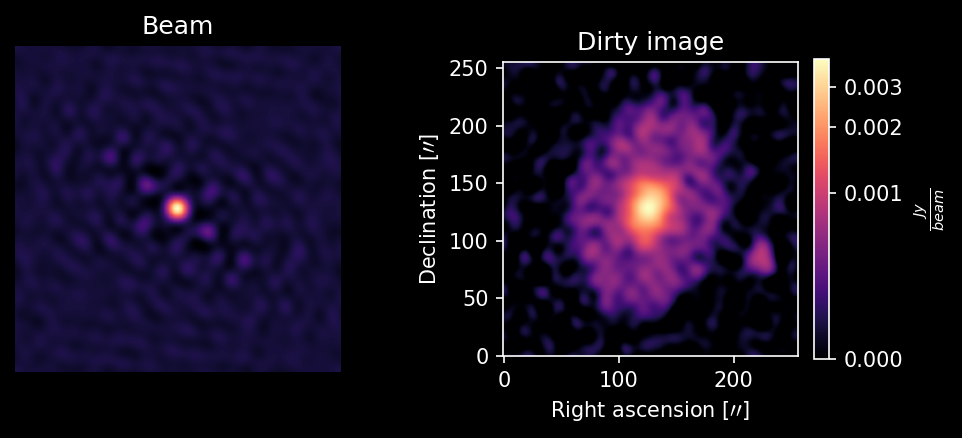

In [3]:
# Plotting... 
fig, axs = plt.subplots(nrows= 1 , ncols = 2, figsize = (7, 3.5))
axs[0].axis("off")

axs[0].imshow(beam.squeeze().real.cpu(), cmap = "magma", origin = "lower")
axs[0].set_title("Beam")

norm = ImageNormalize(dirty_image[..., None, None].cpu().numpy(), vmin = 0, stretch = AsinhStretch())
center = int(npix//2)
ext_pix = int(img_size//2)
im = axs[1].imshow((dirty_image).squeeze()[center-ext_pix:center+ext_pix, center-ext_pix:center+ext_pix].real.cpu(), cmap =  "magma", norm = norm, origin = "lower")
axs[1].set(title = "Dirty image", xlabel = r"Right ascension $[\prime\prime]$", ylabel = r"Declination $[\prime\prime]$")
plt.colorbar(im, fraction = 0.046, label = r"$\frac{Jy}{beam}$")
plt.subplots_adjust(wspace = 0.5)

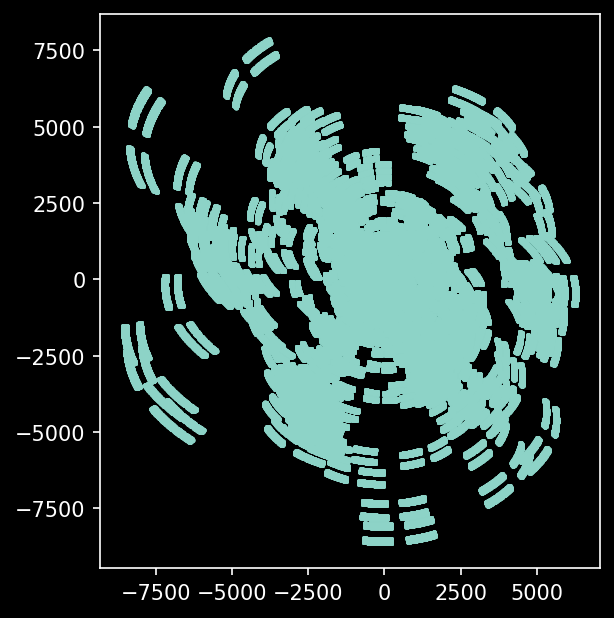

In [31]:
plt.scatter(u, v, s = 1.5, rasterized = True)
plt.gca().set_aspect("equal")

In [31]:

def generate_uv_mask(u, v, nyquist = False, shape = (500, 500), pad_uv = 0.01):
    maxuv = np.max((np.abs(u), np.abs(v)))
    mask_nan, edgex, edgey, binnumber = binned_statistic_2d(u, v, values = np.ones(len(u)), \
                                                                  statistic = "max", bins = shape, \
                                                                  range = ((-maxuv-pad_uv*maxuv, maxuv+pad_uv*maxuv), (-maxuv-pad_uv*maxuv, maxuv+pad_uv*maxuv)))
    mask = np.nan_to_num(mask_nan)
    deltau = 2*(maxuv+pad_uv*maxuv) / shape[0]
    deltav = deltau
    deltal = 1/(shape[0]*deltau) * (180/np.pi) * (3600)
    deltam = deltal
    return mask


mask = generate_uv_mask(u, v, shape = (256, 256), pad_uv = 0)


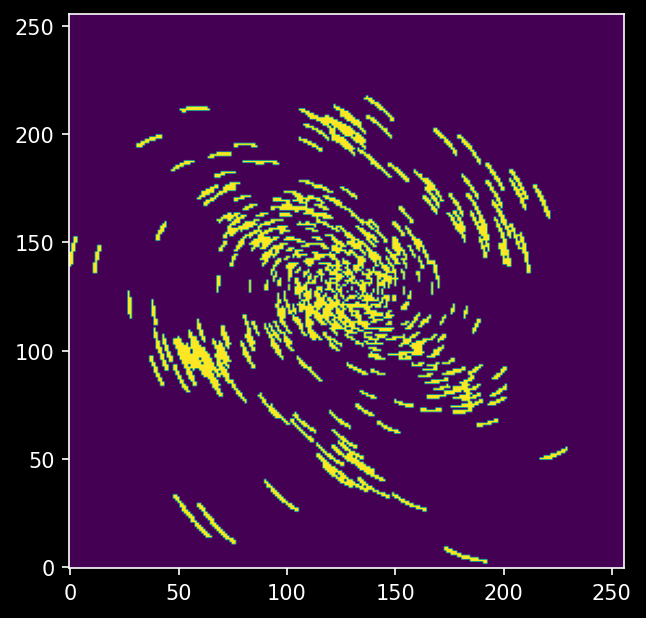

In [22]:
plt.imshow(mask, origin = "lower")

In [4]:
# Including the hermitian pair for each visibility
uu = np.concatenate([u, -u])
vv = np.concatenate([v, -v])
vis_re = np.concatenate([vis.real, vis.real])
vis_imag = np.concatenate([vis.imag, -vis.imag])
weight = np.concatenate([weight, weight])

bin_x = coords.u_edges
bin_y = coords.v_edges
binned_nans, edgex, edgey, binumber = binned_statistic_2d(vv, uu, np.ones(len(uu)), "max",  (bin_y, bin_x))

S = np.nan_to_num(binned_nans)
S = np.fft.fftshift(S)
# std_bin_real = np.fft.fftshift(std_bin_real / (count + 1)**0.5)
# std_bin_imag = np.fft.fftshift(std_bin_imag / (count + 1)**0.5)

In [4]:
# Hermitian augment 
# uu = np.concatenate([u, -u])
# vv = np.concatenate([v, -v])
# vis_re = np.concatenate([vis.real, vis.real])
# vis_imag = np.concatenate([vis.imag, -vis.imag])
# weight = np.concatenate([weight, weight])



# Gridding binned statistics 
bin_x = coords.u_edges
bin_y = coords.v_edges


std_gridded_re, edgex, edgey, binnumber = binned_statistic_2d(vv, uu, vis_re, "std", (bin_y, bin_x))
std_gridded_img, edgex, edgey, binnumber = binned_statistic_2d(vv, uu, vis_imag, "std", (bin_y, bin_x))

count, edgex, edgey, binnumber = binned_statistic_2d(vv, uu, vis_imag, "count", (bin_y, bin_x))

std_gridded_re[np.isnan(std_gridded_re)] = 0
std_gridded_img[np.isnan(std_gridded_img)] = 0


std_gridded_re /= (count + 1) ** 0.5
std_gridded_img /= (count + 1) ** 0.5
S_grid = std_gridded_re.astype(bool)


In [5]:
index_u = np.array(np.digitize(uu, coords.u_edges) - 1)
index_v = np.array(np.digitize(vv, coords.v_edges) - 1)

def gridded_to_loose(gridded_quantity): 
    return gridded_quantity[index_v, index_u]

In [6]:
std_re = gridded_to_loose(std_gridded_re)
std_img = gridded_to_loose(std_gridded_img)

In [8]:
u = data["uu"]
v = data["vv"]
vis = data["data"]
weight = data["weight"]
vis_per_spw = data["vis_per_spw"]


indices = vis_per_spw.cumsum()
spw = 10

if spw == 0: 
    idx_inf = 0
else: 
    idx_inf = indices[spw-1]

idx_sup = indices[spw]
u = u[idx_inf:idx_sup]
v = v[idx_inf:idx_sup]
vis = vis[idx_inf:idx_sup]
weight = weight[idx_inf:idx_sup]

stds = []
from tqdm import tqdm
for i in tqdm(range(500)):

    data_re = std_re[:len(u)] * np.random.normal(loc = np.zeros_like(u))
    data_img = std_img[:len(u)] * np.random.normal(loc = np.zeros_like(u))
    imager = DirtyImager(
    coords=coords,
    uu=u,
    vv=v,
    weight=weight,
    data_re=data_re,
    data_im=data_img
)
    weighting = "briggs"
    robust = -0.4
    imager.get_dirty_image(weighting = weighting, robust = robust)
    std_gridded = imager.vis_gridded * imager.C
    stds.append(std_gridded)
    

100%|██████████| 500/500 [17:02<00:00,  2.04s/it]


In [9]:
stds = np.array(stds)

In [13]:
weight.shape

(3447276,)

In [14]:
imager = DirtyImager(
    coords=coords,
    uu=u,
    vv=v,
    weight=weight,
    data_re=vis.real,
    data_im=vis.imag
)
weighting = "briggs"
robust = -0.4
imager.get_dirty_image(weighting = weighting, robust = robust)





c:\Users\noedi\anaconda3\lib\site-packages\mpol\gridding.py:863: RuntimeWarning: Visibility scatter exceeds ``max_scatter``:1.2, indicating a potential problem with data weights. Consider inspecting weights using CASA tools before exporting visibilities for use with MPoL. Median real scatter: 1.779631363099797 x sigma. Median imag scatter: 1.7817389508531272 x sigma.
  warnings.warn(


In [21]:
vis_gridded = imager.vis_gridded[0] * imager.C
S_grid = imager.mask[0].flatten()

# Already fftshifted
vis_gridded_re = (vis_gridded.real).flatten()
vis_gridded_imag = (vis_gridded.imag).flatten()
std_gridded_re = stds.real.std(axis = 0)[0].flatten()
std_gridded_imag = stds.imag.std(axis = 0)[0].flatten()

vis = np.concatenate([vis_gridded_re, vis_gridded_imag])
std = np.concatenate([std_gridded_re, std_gridded_imag])
sampling_function = np.concatenate([S_grid, S_grid])

S = torch.tensor(sampling_function).to(device)
y = torch.tensor(vis).to(device)[S] * img_size**2
sigma_y = torch.tensor(std).to(device)[S] * img_size

In [22]:
#sigma_y = 1e8 * torch.ones(len(y)).to(device)
#beta = 0
def sigma(t): 
    return sigma_min * (sigma_max/sigma_min) ** t


def model(x, t):
    x = x.reshape(img_size, img_size) # for the FFT 
    x = link_function(x) # map from model unit space to real unit space
    vis_full = ft(torch.fft.fftshift(x)).flatten() 
    vis_sampled = vis_full
    vis_sampled = torch.cat([vis_sampled.real, vis_sampled.imag])
    return vis_sampled[S]


def log_likelihood(y, x, t, sigma_y):
    """
    Calculate the log-likelihood of a gaussian distribution 
    Arguments: 
        y = processed gridded visibilities (real part and imaginary part concatenated)
        x = sky brightness 
        t = diffusion temperature
        A = linear model (sampling function and FT)  
    
    Returns: 
        log-likelihood of a gaussian distribution
    """ 
    y_hat = model(x, t)
    var = sigma(t) **2 / 2  + sigma_y**2
    log_prob = -0.5 * torch.sum((y - y_hat)**2 / var)
    return log_prob


# GIVE THE GOOD COVARIANCE MATRIX
def score_likelihood(y, x, t, sigma_y): 
    x = x.flatten(start_dim = 1) 
    return vmap(grad(lambda x, t: log_likelihood(y, x, t, sigma_y)), randomness = "different")(x, t)

#torch.manual_seed(0)
def score_posterior(x, t): 
    x = x.reshape(-1, 1, img_size, img_size)
    return score_model.score(t, x).flatten(start_dim = 1) + score_likelihood(y, x, t, sigma_y) 

k = torch.randn([1, img_size ** 2]).to(device) 
t = torch.ones([1]).to(device)

print((torch.sum(score_likelihood(y, k, t, sigma_y)**2))**0.5)
print(score_posterior(k, t))

tensor(0.0017, device='cuda:0')
tensor([[-0.0002, -0.0021, -0.0011,  ..., -0.0009, -0.0035, -0.0039]],
       device='cuda:0', grad_fn=<AddBackward0>)


In [23]:
def g(t): 
    return sigma(t) * np.sqrt(2 * (np.log(sigma_max) - np.log(sigma_min)))
def pc_sampler(num_samples, num_pred_steps, num_corr_steps, score_function, snr = 1e-2, img_size = 28): 
    t = torch.ones(size = (num_samples, 1)).to(device)
    x = torch.randn([num_samples, img_size ** 2]).to(device)
    dt = -1/num_pred_steps
    with torch.no_grad(): 
        for _ in tqdm(range(num_pred_steps-1)): 
            # Corrector step: (Only if we are not at 0 temperature )
            gradient = score_function(x, t)
            for _ in range(num_corr_steps): 
                z = torch.randn_like(x)
                grad_norm = torch.mean(torch.norm(gradient, dim = -1)) # mean of the norm of the score over the batch 
                noise_norm = torch.mean(torch.norm(z, dim = -1))
                epsilon =  2 * (snr * noise_norm / grad_norm) ** 2
                x = x + epsilon * gradient + (2 * epsilon) ** 0.5 * z * dt  

        
            # Predictor step: 
            z = torch.randn_like(x).to(device)
            gradient = score_function(x, t)
            drift = 0
            diffusion = g(t)
            x_mean = x - diffusion**2 * gradient * dt  
            noise = diffusion * (-dt) ** 0.5 * z
            x = x_mean + noise
            t += dt
            if torch.any(torch.isnan(x_mean)):
                print("Nans appearing")
                break
            
    return link_function(x_mean)

def euler_sampler(num_samples, num_steps, score_function, img_size = 28): 
    t = torch.ones(size = (num_samples, 1)).to(device)
    x = sigma_max * torch.randn([num_samples, img_size ** 2]).to(device)
    dt = -1/num_steps
    with torch.no_grad(): 
        for _ in tqdm(range(num_steps - 1)): 
            z = torch.randn_like(x).to(device)
            gradient = score_function(x, t)
            drift = 0
            diffusion = g(t)
            x_mean = x - diffusion**2 * gradient * dt  
            noise = diffusion * (-dt) ** 0.5 * z
            x = x_mean + noise
            t += dt

            #print(score_likelihood(x, t))
            if torch.any(torch.isnan(x_mean)):
                print("Nans appearing")
                break
    
    return link_function(x_mean)

pred = 500
corr = 100
snr = 1e-2
samples = euler_sampler(num_samples = 1, num_steps = pred, score_function = score_posterior, img_size = img_size)
#samples = pc_sampler(num_samples = 1, num_pred_steps = pred, num_corr_steps = corr, snr = snr, score_function = score_posterior, img_size = img_size)

100%|██████████| 499/499 [01:49<00:00,  4.55it/s]


In [41]:
samples.max()

tensor(2.0235e-05, device='cuda:0')

True


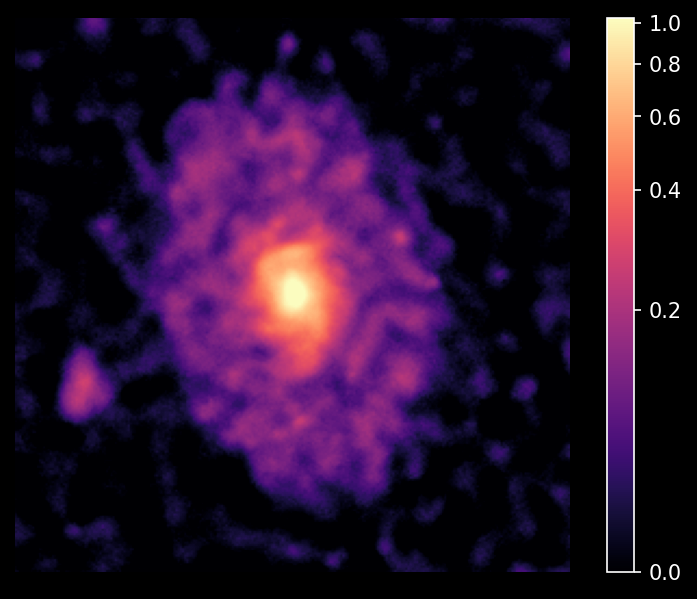

: 

In [24]:
norm = True
save = False
n_images = len(samples)
grid_size = int(n_images**0.5)
if n_images != 1:
    fig, axs = plt.subplots(grid_size, grid_size, figsize = (5, 5))
    norm = ImageNormalize(dirty_image[..., None, None].cpu().numpy(), vmin = 0, stretch = AsinhStretch())
    k = 0
    for i in range(grid_size):
        for j in range(grid_size): 
            im = axs[i, j].imshow((samples[k]).cpu().reshape(img_size, img_size), cmap = "magma", norm = norm, origin = "lower")
            axs[i, j].axis("off")
            #if k==0: 
                #plt.colorbar(im)
            k+=1
else: 
    print(norm)
    if norm:
        save_path = f"../../images/HTLup_pad{npix}_robustnorm.jpeg"
        norm = ImageNormalize(samples.cpu().numpy(), vmin = 0, stretch = AsinhStretch())
    else: 
        save_path = f"../../images/HTLup_pad{npix}_robustnonorm.jpeg"
        norm = None
    plt.imshow((samples).cpu().reshape(img_size, img_size), cmap = "magma", norm = norm, origin = "lower")
    plt.axis("off")
    plt.colorbar()
if save: 
    plt.savefig(save_path, bbox_inches = "tight", pad_inches = 0.1)

In [31]:
samples.shape

torch.Size([1, 65536])

In [16]:
robust = 0.0
f"{robust:.1f}"

'0.0'

In [57]:
I = torch.ones(D).to(device)

In [61]:
S.shape

torch.Size([1, 512, 512])

In [58]:
D

262144